# The GameStop Saga

### Objectives
1. Use the yFinance python package to extract stock and historical share price information for two companies, Apple and GameStop.
2. Use webscaping to find revenue data for the same companies.
3. Cleanse, visualise and compare the data.

Install packages

Import packages

In [1]:
import yfinance as yf
import pandas as pd
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mplfinance as mpf

### 1.Using the yFinance python package to extract stock, historical share price and information
Extract stock information for Apple

In [2]:
apple = yf.Ticker('AAPL')

print(apple.info['longName'], '\n', 
      apple.info['country'], '\n', 
      apple.info['industry'], '\n', 
      apple.info['website'], '\n', sep='')
#print(apple.info)

Apple Inc.
United States
Consumer Electronics
https://www.apple.com



Extract stock information for GameStop

In [3]:
game = yf.Ticker('GME')

print(game.info['longName'], '\n', 
      game.info['country'], '\n', 
      game.info['industry'], '\n', 
      game.info['website'], '\n', sep='')
# print(game.info)

GameStop Corp.
United States
Specialty Retail
https://www.gamestop.com



### 2. Using webscaping to find revenue data for the same companies
Scrape the annual revenue table from (https://www.macrotrends.net/stocks/charts/AAPL/apple/revenue) for Apple

In [4]:
apple_url = 'https://www.macrotrends.net/stocks/charts/AAPL/apple/revenue'
apple_headers = {'User-Agent': 'CoolBot/0.0 (https://example.org/coolbot/; coolbot@example.org)'}
apple_html = requests.get(apple_url, headers=apple_headers).text
apple_soup = BeautifulSoup(apple_html, 'html.parser')

# print(apple_soup)

In [5]:
apple_table = apple_soup.find('table', {'class': 'historical_data_table table'})
apple_rows = apple_table.find_all('tr')
apple_cols = ['Year', 'Annual Revenue ($m)']
apple_revenue = pd.DataFrame(columns = apple_cols)
for index, apple_row in enumerate(apple_table.find_all("tr")):
    if index > 0:
        col = apple_row.find_all("td")
        date = col[0].text
        revenue = col[1].text
        new_row = pd.DataFrame([[date, revenue]], columns = apple_cols)
        apple_revenue = pd.concat([apple_revenue, new_row], ignore_index=True)

apple_revenue['Annual Revenue ($m)'] = (
    apple_revenue['Annual Revenue ($m)']
    .str.replace('$', '', regex=False)
    .str.replace(',', '', regex=False)
    .astype(int))

apple_revenue['Date'] = pd.to_datetime(apple_revenue['Year'].astype(str) + '-12-31')
apple_revenue.set_index('Date', inplace=True)
apple_revenue.index = pd.to_datetime(apple_revenue.index)
apple_revenue.sort_values(by='Date', inplace=True)

# print(apple_revenue.info())
#print(apple_revenue.head(5))

Scrape the annual revenue table from (https://www.macrotrends.net/stocks/charts/GME/gamestop/revenue) for Gamestop

In [6]:
game_url = 'https://www.macrotrends.net/stocks/charts/GME/gamestop/revenue'
game_headers = {'User-Agent': 'CoolBot/0.0 (https://example.org/coolbot/; coolbot@example.org)'}
game_html = requests.get(game_url, headers=game_headers).text
game_soup = BeautifulSoup(game_html, 'html.parser')

# print(game_soup)

In [7]:
game_table = game_soup.find('table', {'class': 'historical_data_table table'})
game_rows = game_table.find_all('tr')
game_cols = ['Year', 'Annual Revenue ($m)']
game_revenue = pd.DataFrame(columns = game_cols)
for index, game_row in enumerate(game_table.find_all("tr")):
    if index > 0:
        col = game_row.find_all("td")
        date = col[0].text
        revenue = col[1].text
        new_row = pd.DataFrame([[date, revenue]], columns = game_cols)
        game_revenue = pd.concat([game_revenue, new_row], ignore_index=True)

game_revenue['Annual Revenue ($m)'] = (
    game_revenue['Annual Revenue ($m)']
    .str.replace('$', '', regex=False)
    .str.replace(',', '', regex=False)
    .astype(int))

game_revenue['Date'] = pd.to_datetime(game_revenue['Year'].astype(str) + '-12-31')
game_revenue.set_index('Date', inplace=True)
game_revenue.index = pd.to_datetime(game_revenue.index)
game_revenue.sort_values(by='Date', inplace=True)

# print(game_revenue.info())
#print(game_revenue.head(5))

### 3. Visualise and compare the data
Plot revenue and share price data for Apple

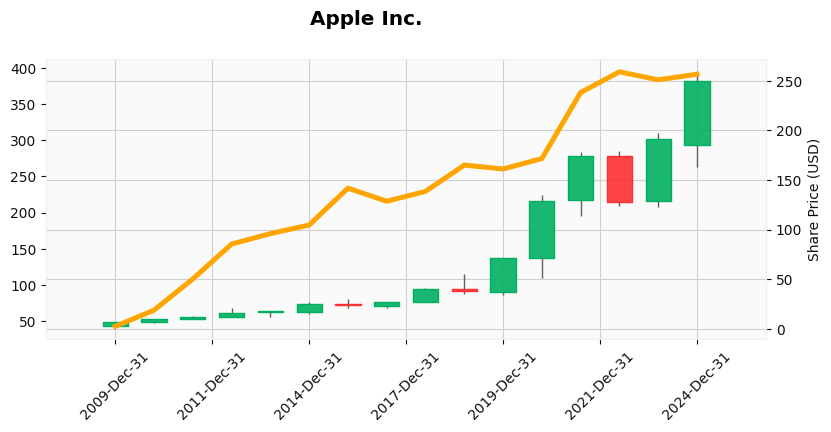

In [8]:
from datetime import date

# Get share price data
today = date.today()
apple_share_price_data = apple.history(start="2009-01-01", end=today)

# Resample to yearly candlestick format
apple_yearly = apple_share_price_data.resample('YE').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last'
})
apple_yearly.index = apple_yearly.index.tz_localize(None).normalize()
apple_revenue.index = apple_revenue.index.tz_localize(None).normalize()

# Align both datasets
shared_index = apple_yearly.index.intersection(apple_revenue.index)
apple_yearly = apple_yearly.loc[shared_index]
apple_revenue = apple_revenue.loc[shared_index]

# Convert revenue to billions
apple_revenue['Revenue (B USD)'] = apple_revenue['Annual Revenue ($m)'] / 1000

# Create revenue overlay
revenue_overlay = mpf.make_addplot(
    apple_revenue['Revenue (B USD)'],
    type='line',
    color='orange',
    secondary_y=True
)

# Plot candlestick chart with overlay
mpf.plot(
    apple_yearly,
    type='candle',
    style='yahoo',
    title=apple.info['longName'],
    ylabel='Share Price (USD)',
    addplot=revenue_overlay,
    volume=False,
    figsize=(10, 4)
)

Plot revenue and share price data for GamesStop

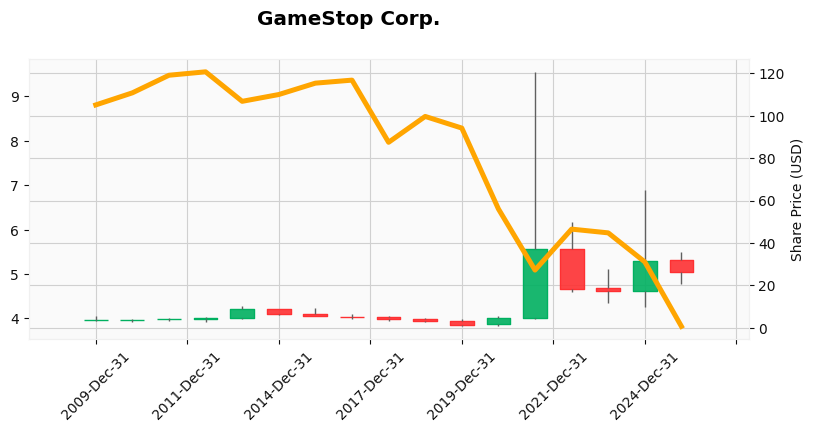

In [10]:
# Get share price data
today = date.today()
game_share_price_data = game.history(start="2009-01-01", end=today)

# Resample to yearly candlestick format
game_yearly = game_share_price_data.resample('YE').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last'
})
game_yearly.index = game_yearly.index.tz_localize(None).normalize()
game_revenue.index = game_revenue.index.tz_localize(None).normalize()

# Align both datasets
shared_index = game_yearly.index.intersection(game_revenue.index)
game_yearly = game_yearly.loc[shared_index]
game_revenue = game_revenue.loc[shared_index]

# Convert revenue to billions
game_revenue['Revenue (B USD)'] = game_revenue['Annual Revenue ($m)'] / 1000

# Create revenue overlay
revenue_overlay = mpf.make_addplot(
    game_revenue['Revenue (B USD)'],
    type='line',
    color='orange',
    secondary_y=True
)

# Plot candlestick chart with overlay
mpf.plot(
    game_yearly,
    type='candle',
    style='yahoo',
    title=game.info['longName'],
    ylabel='Share Price (USD)',
    addplot=revenue_overlay,
    volume=False,
    figsize=(10, 4)
)

For Apple we can see share prices increase as revenues increase, as you would expect.

For Gamestop we can see the opposite, as as result of the highly publicised 'GameStop Saga', where Retail investors, particularly from the subreddit r/wallstreetbets communities, began buying GameStop shares and options, driving the price up. This buying frenzy was fueled by a belief that the stock was undervalued and a desire to challenge institutional investors.
